Carlos Manuel Alvarado Alvarado 20200118
- Python 3.9.16 de ambiente. 

In [9]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import cvlib

In [27]:
img = cv.imread('subimage.pgm', cv.IMREAD_GRAYSCALE)
#img = cv.imread(os.path.join(PATH,'Unequalized_Hawkes_Bay_NZ.jpg'), cv.IMREAD_GRAYSCALE)

r,c = img.shape[0:2]
print('Rows {0}\nColumns {1}\nPixels {2:,}'.format(r,c,r*c))

Rows 8
Columns 8
Pixels 64


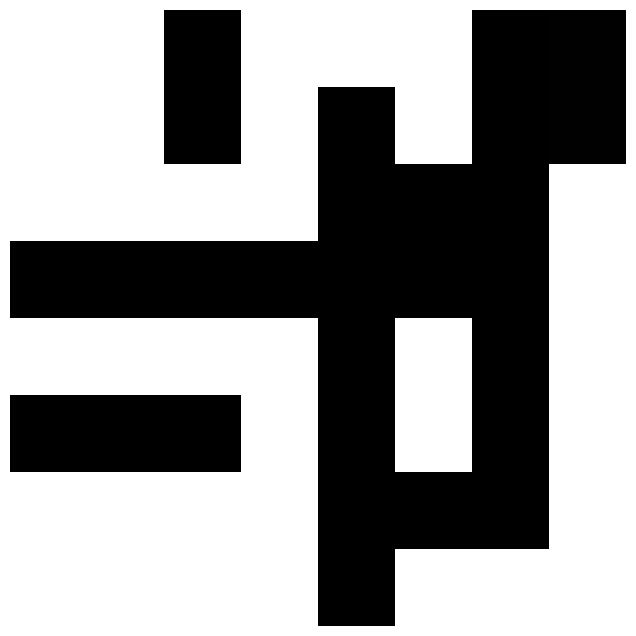

In [28]:
cvlib.imgview(img)

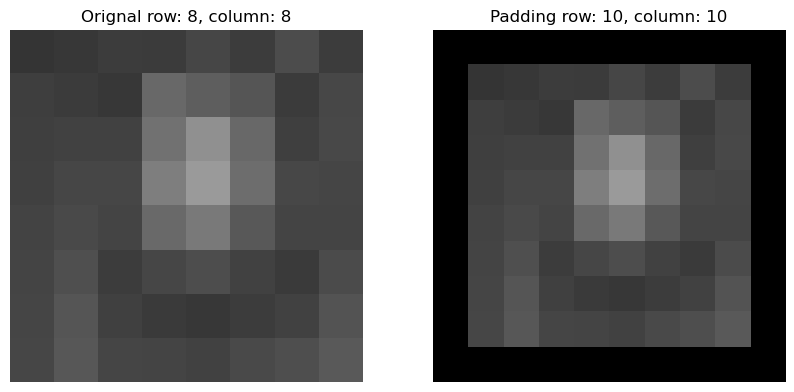

In [18]:
def imgpad(image, r):
    """_summary_
        La función empieza obteniendo el valor de columnas y filas de la imagen original. 
        Eso nos sirve, porque el padding es agregar un "marco" a la imagen, por lo que sabemos que
        r * 2 nos generara los espacios necesarios para el nuevo lenght de cada fila de la imagen. 
                                                                                    filas       columnas
        Por lo tanto, se crea un array con np.zero de numpy y sus dimensiones son: (row+(r*2), column+(r*2)
        Por ejemplo, si la imagen es de 8 * 8, tendremos una de 10 * 10, para tener 1 pixel de marco con el padding. 
        
        Para poner la imagen dentro de la matriz, le caemos encima a el espacio que equivale a donde estaría la imagen
        original. Eso nos trae justamente el espacio en donde corresponde nuestra imagen inicial. 
    Args:
        image (uint8): array de la imagen
        r (int): cantidad de pixeles que queremos nuestro padding. 
    """
    row,column = image.shape[0:2]
    arr = np.zeros((row+(r*2), column+(r*2)))
    arr[r:r+row, r:r+column] = image
    return arr

img2 = imgpad(img, 1)
r,c = img.shape[0:2]
r2,c2 = img2.shape[0:2]
cvlib.imgcmp(img, img2, title=['Orignal row: {0}, column: {1}'.format(r,c),'Padding row: {0}, column: {1}'.format(r2,c2)])

Fist_pass

In [21]:
def first_pass(img):
    
    return img

UNION-FIND

In [5]:
def find(data, i):
    if i != data[i]:
        data[i] = find(data, data[i])
    return data[i]
def union(data, i, j):
    pi, pj = find(data, i), find(data, j)
    if pi != pj:
        data[pi] = pj

In [6]:
n = 10
data = [i for i in range(n)]
print(data)
connections = [(0, 1), (1, 2), (0, 9), (5, 6), (6, 4), (5, 9)]
print(connections)
# union
for i, j in connections:
    union(data, i, j)
    print(data)
# find
for i in range(n):
    print('item', i, '-> component', find(data, i))
    print(data)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[(0, 1), (1, 2), (0, 9), (5, 6), (6, 4), (5, 9)]
[1, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 2, 2, 3, 4, 5, 6, 7, 8, 9]
[2, 2, 9, 3, 4, 5, 6, 7, 8, 9]
[2, 2, 9, 3, 4, 6, 6, 7, 8, 9]
[2, 2, 9, 3, 4, 6, 4, 7, 8, 9]
[2, 2, 9, 3, 9, 4, 4, 7, 8, 9]
item 0 -> component 9
[9, 2, 9, 3, 9, 4, 4, 7, 8, 9]
item 1 -> component 9
[9, 9, 9, 3, 9, 4, 4, 7, 8, 9]
item 2 -> component 9
[9, 9, 9, 3, 9, 4, 4, 7, 8, 9]
item 3 -> component 3
[9, 9, 9, 3, 9, 4, 4, 7, 8, 9]
item 4 -> component 9
[9, 9, 9, 3, 9, 4, 4, 7, 8, 9]
item 5 -> component 9
[9, 9, 9, 3, 9, 9, 4, 7, 8, 9]
item 6 -> component 9
[9, 9, 9, 3, 9, 9, 9, 7, 8, 9]
item 7 -> component 7
[9, 9, 9, 3, 9, 9, 9, 7, 8, 9]
item 8 -> component 8
[9, 9, 9, 3, 9, 9, 9, 7, 8, 9]
item 9 -> component 9
[9, 9, 9, 3, 9, 9, 9, 7, 8, 9]
